In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [17]:
# Define Black-Scholes call option price

N = norm.cdf


# Black-Scholes Formula for European Call and Put Options
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Must be 'call' or 'put'.")

    return option_price

In [5]:
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.15

In [7]:
msft = yf.Ticker("MSFT")


# get historical market data
hist = msft.history(period="1mo")

print(hist)


                                 Open        High         Low       Close  \
Date                                                                        
2024-07-29 00:00:00-04:00  430.803499  431.372481  423.935903  425.962250   
2024-07-30 00:00:00-04:00  426.950471  428.278064  416.609094  422.159119   
2024-07-31 00:00:00-04:00  419.743446  421.021142  411.468353  417.597321   
2024-08-01 00:00:00-04:00  420.032930  426.690912  412.346771  416.359528   
2024-08-02 00:00:00-04:00  411.747839  414.253332  403.612508  407.755035   
2024-08-05 00:00:00-04:00  388.469835  400.318474  384.886267  394.439056   
2024-08-06 00:00:00-04:00  399.280335  404.940147  397.783033  398.891022   
2024-08-07 00:00:00-04:00  407.904818  409.342199  396.754901  397.713165   
2024-08-08 00:00:00-04:00  401.715934  405.129764  399.220432  401.965485   
2024-08-09 00:00:00-04:00  403.303080  407.315836  401.536275  405.289490   
2024-08-12 00:00:00-04:00  406.327614  408.024568  403.512681  406.078064   

In [12]:
hist['Daily Return'] = hist['Close'].pct_change()

volatility = hist['Daily Return'].std() * np.sqrt(252)

print(f"The annualized volatility for MSFT over the last month is: {volatility:.2%}")


The annualized volatility for MSFT over the last month is: 19.48%


In [20]:
S = hist['Close'].iloc[-1]
K = 100
T = 1
r = 0.05
sigma = volatility

# Define the expiration times in years
expiration_times = [1/12, 0.5, 1]  # 1 month, 6 months, 1 year

# Calculate strike prices
strike_prices = [S, S * 0.9, S * 1.1]  # At the money, 10% below, 10% above



In [22]:
# Calculate option prices for each expiration and strike price
option_prices = []
for T in expiration_times:
    for K in strike_prices:
        call_price = black_scholes(S, K, T, r, sigma, option_type="call")
        put_price = black_scholes(S, K, T, r, sigma, option_type="put")
        option_prices.append({
            'Expiration (years)': T,
            'Strike Price': K,
            'Call Price': call_price,
            'Put Price': put_price
        })

# Display the calculated option prices
for option in option_prices:
    print(f"Expiration: {option['Expiration (years)']} years, Strike Price: ${option['Strike Price']:.2f}")
    print(f"Call Option Price: ${option['Call Price']:.2f}, Put Option Price: ${option['Put Price']:.2f}")
    print("-" * 50)

Expiration: 0.08333333333333333 years, Strike Price: $410.60
Call Option Price: $10.07, Put Option Price: $8.36
--------------------------------------------------
Expiration: 0.08333333333333333 years, Strike Price: $369.54
Call Option Price: $42.81, Put Option Price: $0.21
--------------------------------------------------
Expiration: 0.08333333333333333 years, Strike Price: $451.66
Call Option Price: $0.53, Put Option Price: $39.72
--------------------------------------------------
Expiration: 0.5 years, Strike Price: $410.60
Call Option Price: $27.70, Put Option Price: $17.56
--------------------------------------------------
Expiration: 0.5 years, Strike Price: $369.54
Call Option Price: $55.06, Put Option Price: $4.88
--------------------------------------------------
Expiration: 0.5 years, Strike Price: $451.66
Call Option Price: $11.39, Put Option Price: $41.30
--------------------------------------------------
Expiration: 1 years, Strike Price: $410.60
Call Option Price: $42.11

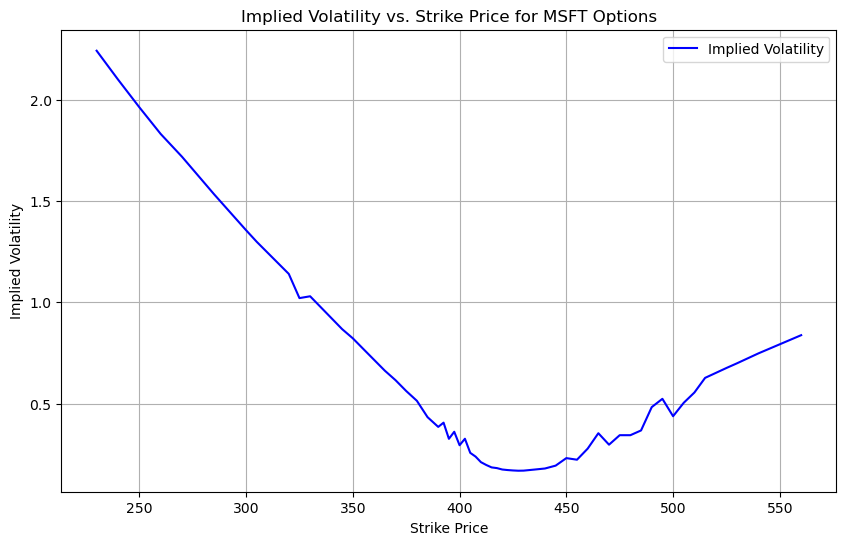

In [35]:
# FETCH OPTIONS CHAIN DATA FOR THE COMPANY
msft_options = msft.option_chain()

# ACCESS BOTH THE CALLS AND PUTS AND STORE THEM IN THEIR RESPECTIVE VARIABLES
msft_puts = msft_options.puts
msft_calls = msft_options.calls

strike_prices = msft_calls['strike']
implied_volatility = msft_calls['impliedVolatility']

# Plot implied volatility vs. strike price
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, implied_volatility, linestyle='-', color='b', label='Implied Volatility')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title(f'Implied Volatility vs. Strike Price for MSFT Options')
plt.grid(True)
plt.legend()
plt.show()



In [38]:
# Vega: Sensitivity of option price to volatility
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

# Newton-Raphson method to find implied volatility
def find_implied_volatility(market_price, S, K, T, r, option_type="call", initial_guess=0.2, tol=1e-6, max_iter=100):
    sigma = initial_guess
    for i in range(max_iter):
        price = black_scholes(S, K, T, r, sigma, option_type)
        v = vega(S, K, T, r, sigma)
        
        # Update using Newton-Raphson formula
        sigma_new = sigma - (price - market_price) / v
        
        # Check for convergence
        if abs(sigma_new - sigma) < tol:
            return sigma_new
        
        sigma = sigma_new
        
    raise ValueError("Implied volatility did not converge")

# User-defined input for the stock ticker, strike price, and expiration date
ticker = "AAPL"  # Example: Apple Inc.
strike_price = 400  # Example strike price (arbitrary value)

# Fetch stock data
stock = yf.Ticker(ticker)
current_price = 400  # Latest closing price

# Find the market price for the specified strike price
market_price = 20

# Other parameters
T = 0.1
risk_free_rate = 0.03  # Example risk-free rate

# Calculate implied volatility using Newton-Raphson method
try:
    implied_volatility = find_implied_volatility(market_price, current_price, strike_price, T, risk_free_rate, "call")
    print(f"The implied volatility for AAPL at strike price $400 is: {implied_volatility:.2%}")
except ValueError as e:
    print(str(e))

The implied volatility for AAPL at strike price $400 is: 38.52%


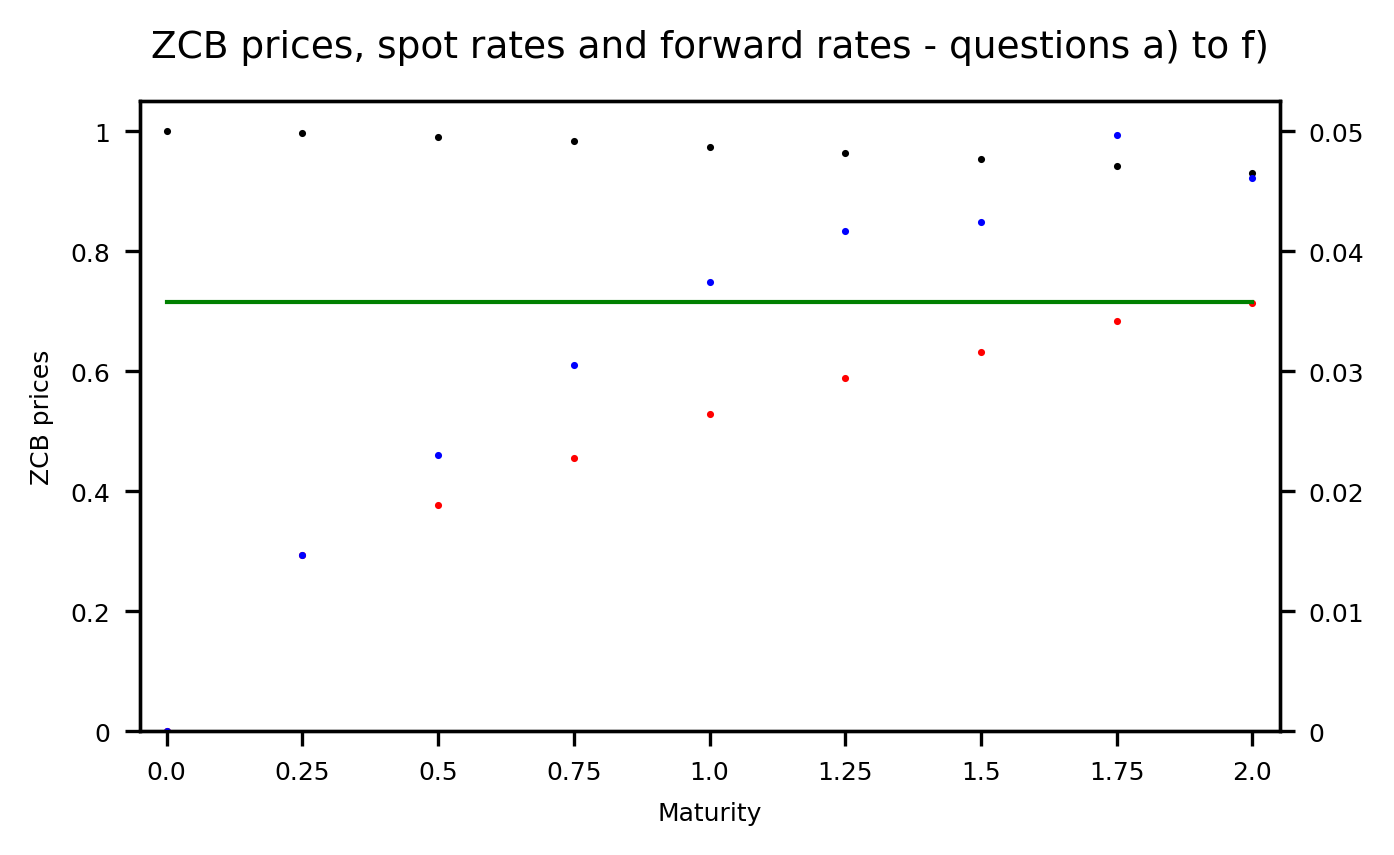

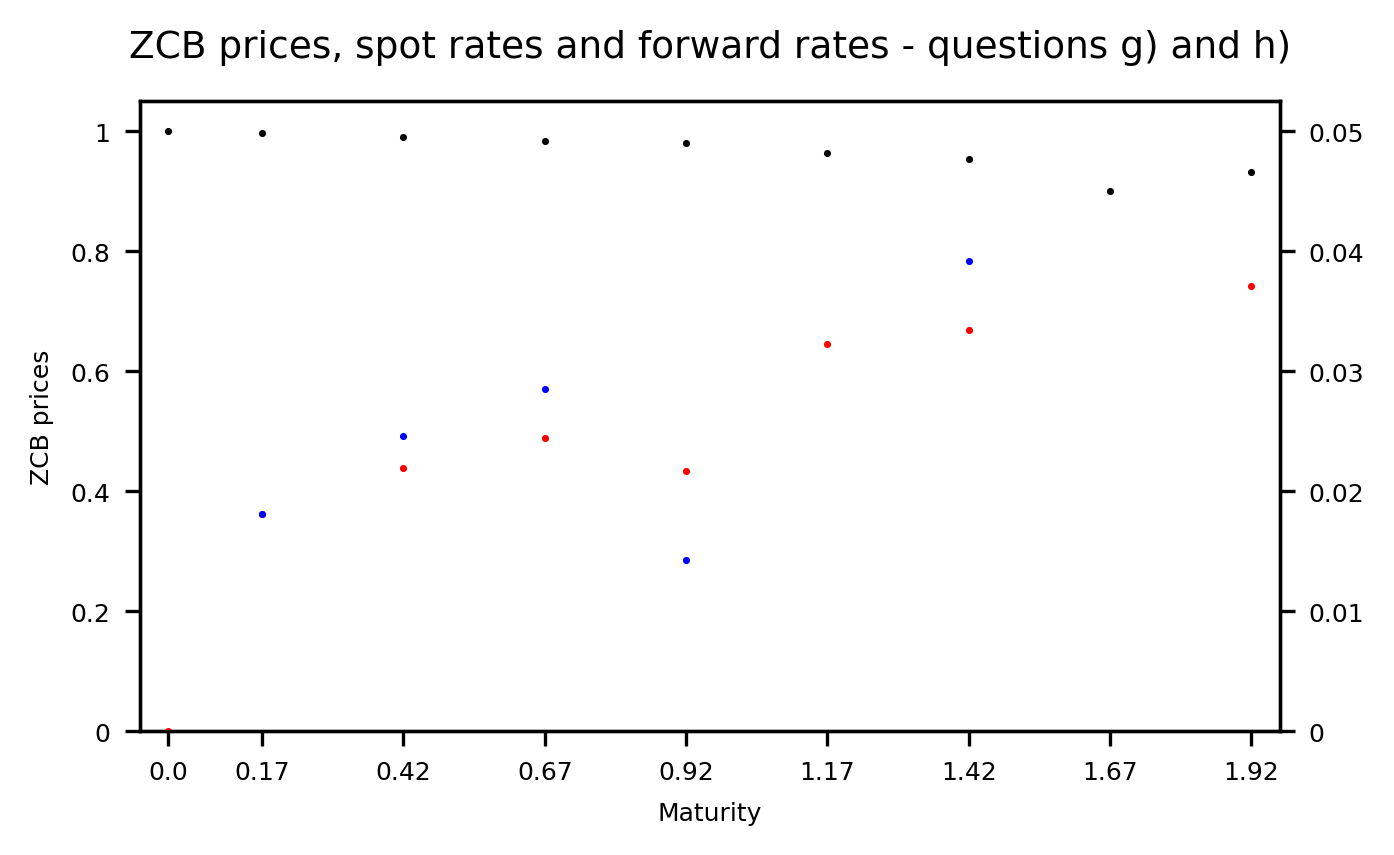

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N, M = 6, 9
K = 100
T = np.array([0,0.25,0.5,0.75,1,1.25,1.5,1.75,2])
L_3M, L_6M = 0.01472717, 0.01893706
pi = np.array([102.33689177,104.80430234,105.1615306,105.6581905,104.02899992,101.82604116])
pi_new = np.array([101.98667646,102.96333877,102.68122237,104.17312216,102.76231402,98.8174065])
p_0_2M_new, p_0_5M_new = 0.99699147, 0.99088748
pi_swap_new = 0.02515099

# Problem a)
C = np.zeros([N,M])
C[0,:] = [0.04*K*0.25,0.04*K*0.25,0.04*K*0.25,0.04*K*0.25,0.04*K*0.25+K,0,0,0,0]
C[1,:] = [0.05*K*0.5,0,0.05*K*0.5,0,0.05*K*0.5+K,0,0,0,0]
C[2,:] = [0.05*K*0.5,0,0.05*K*0.5,0,0.05*K*0.5,0,0.05*K*0.5+K,0,0]
C[3,:] = [0.06*K*0.25,0.06*K*0.25,0.06*K*0.25,0.06*K*0.25,0.06*K*0.25,0.06*K*0.25,0.06*K*0.25+K,0,0]
C[4,:] = [0.05*K*0.25,0.05*K*0.25,0.05*K*0.25,0.05*K*0.25,0.05*K*0.25,0.05*K*0.25,0.05*K*0.25,0.05*K*0.25,0.05*K*0.25+K]
C[5,:] = [0.03*K*1,0,0,0,0.03*K*1,0,0,0,0.03*K*1+K]

# Problem b)
p, r = np.ones([M]), np.zeros([M])
p[1], p[2] = 1/(1+L_3M*T[1]), 1/(1+L_6M*T[2])
y = pi-p[0]*C[:,0]-p[1]*C[:,1]-p[2]*C[:,2]
x = C[:,3:]
p[3:M] = np.linalg.solve(x,y)
for i in range(1,M):
    r[i] = -np.log(p[i])/T[i]

# Problem c)
f_3M = np.zeros([M])
f_3M[0] = r[0]
for i in range(1,M):
    f_3M[i] = -(np.log(p[i])-np.log(p[i-1]))/(T[i]-T[i-1])

# Problem d)
pi_float = K*p[0]

# Problem e)
R = (1-p[8])/(0.5*(p[2]+p[4]+p[6]+p[8]))

T_new = np.zeros([M])
T_new[1:] = T[1:] - 1/12
C_new = np.zeros([N,M])
C_new[:,1:] = C[:,1:]

# problem g)
C_swap = np.array([0,-0.25*K*L_3M-K,0.5*R*K,0,0.5*R*K,0,0.5*R*K,0,0.5*R*K+K])

# problem h)
p_new = np.ones([M])
p_new[0], p_new[1], p_new[2] = 1, p_0_2M_new, p_0_5M_new
C_new = np.vstack([C_new,C_swap])
y = np.hstack([pi_new,pi_swap_new]) - p_new[1]*C_new[:,1] - p_new[2]*C_new[:,2]
x = C_new[:,3:]
p_new[3:] = np.linalg.solve(np.matmul(np.transpose(x),x),np.matmul(np.transpose(x),y))
r_new, f_3M_new = np.zeros([M]), np.zeros([M])
f_3M_new[0] = np.nan
for i in range(1,M):
    r_new[i] = -np.log(p_new[i])/T_new[i]
    f_3M_new[i] = -(np.log(p_new[i])-np.log(p_new[i-1]))/(T_new[i]-T_new[i-1])

# Plot for quextions a) - e)
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"ZCB prices, spot rates and forward rates - questions a) to f)", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

ax.set_xticks(T)
ax.set_xticklabels(T,fontsize = 6)
ax.set_xlim([T[0]-0.05,T[-1]+0.05])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"ZCB prices",fontsize = 6)
ax.scatter(T, p, s = 2, color = 'black', marker = ".")

ax1 = ax.twinx()
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 6)
ax1.set_ylim([0,0.0525])
ax1.scatter(T, r, s = 2, color = 'red', marker = ".")
ax1.scatter(T, f_3M, s = 2, color = 'blue', marker = ".")
ax1.plot(T,R*np.ones([M]), color='green', linewidth = 1, marker = "")

# Plot for quextions g) - h)
fig2 = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig2.suptitle(f"ZCB prices, spot rates and forward rates - questions g) and h)", fontsize = 9)
gs = fig2.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig2.add_subplot(gs[0,0])

xtick_labels = [round(T_new[i],2) for i in range(0,M)]
ax.set_xticks(T_new)
ax.set_xticklabels(xtick_labels,fontsize = 6)
ax.set_xlim([T_new[0]-0.05,T_new[-1]+0.05])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"ZCB prices",fontsize = 6)
ax.scatter(T_new, p_new, s = 2, color = 'black', marker = ".")

ax1 = ax.twinx()
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 6)
ax1.set_ylim([0,0.0525])
ax1.scatter(T_new, r_new, s = 2, color = 'red', marker = ".")
ax1.scatter(T_new, f_3M_new, s = 2, color = 'blue', marker = ".")

plt.show()
